# Build a recommender system by using cosine simillarties score
---

There are two types of filtering in a Recommender system:
1. CONTENT-BASED FILTERING : Content-based recommender systems recommend items similar to the ones the user has liked before. The system analyzes the characteristics of the items that the user has already rated positively, such as genre, author, or director, and recommends items with similar attributes. This type of recommender system works well for recommending products that have well-defined and easily measurable attributes.
2. COLLABORATIVE FILTERING : Collaborative filtering recommender systems recommend items based on the user's behavior and preferences, as well as the behavior and preferences of other users with similar tastes. This system works by analyzing the user's past behavior, such as the items they have rated or purchased, and recommending items that have been highly rated by other users with similar preferences. Collaborative filtering can be further divided into two categories: 
    - USER-BASED : User-based filtering recommends items based on the preferences of users with similar interests. 
    - ITEM-BASED : item-based filtering recommends items based on similarities between items.

## Exploratory Data Analysis

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setting style for plots
plt.style.use('seaborn-v0_8')

In [3]:
# Loading the dataset while ignoring encoding errors and using 'Unnamed: 0' as the index
books = pd.read_csv('book.csv', encoding_errors='ignore', index_col = 'Unnamed: 0')

In [4]:
# Getting the shape of the dataset
books.shape

(10000, 3)

There are 10 thousand entries

In [5]:
# Getting details of the columns
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User.ID      10000 non-null  int64 
 1   Book.Title   10000 non-null  object
 2   Book.Rating  10000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 312.5+ KB


The 3 features are :
1. User ID
2. Title of the book
3. Rating for the book  

There are no na values in any of them

In [6]:
# Renaming the columns
books.columns = ['user_id', 'book_title', 'book_rating']

In [7]:
# Getting unique values for each column
books.nunique()

user_id        2182
book_title     9659
book_rating      10
dtype: int64

There are 2182 total users, 9659 books, and 10 rating levels

In [8]:
# Checking for duplicated rows
books[books.duplicated()]

,user_id,book_title,book_rating
5052,2152,Le nouveau soleil de Teur,7
7440,3757,The Magician's Tale,7


In [9]:
# Dropping duplicated rows
books.drop(index = books[books.duplicated()].index, inplace = True)

In [10]:
# Resetting index after we've removed some rows
books.reset_index(drop = True, inplace = True)

In [11]:
books.user_id.nunique()

2182

There are 2182 users

In [12]:
# Getting the number of books a user has rated
user_value_counts = books.user_id.value_counts().to_frame(name = 'n_books_rated').reset_index(names = 'user_id')
user_value_counts

,user_id,n_books_rated
0,3757,522
1,162052,214
2,2276,212
3,4017,156
4,277427,150
...,...,...
2177,969,1
2178,967,1
2179,965,1
2180,951,1


In [13]:
# Getting a dataframe of entries where users have rated more than 1 book
user_value_counts[user_value_counts.n_books_rated != 1]

,user_id,n_books_rated
0,3757,522
1,162052,214
2,2276,212
3,4017,156
4,277427,150
...,...,...
854,4035,2
855,433,2
856,3197,2
857,1759,2


Out of 2182, only 859 users have rated multiple books. 1323 users have rated a single book. It will be difficult to recommend books for them, unless we use content based filtering, but we only have the book title here.

In [14]:
# Getting the number of users who have rated a specific number of books
rating_rate = user_value_counts.n_books_rated.value_counts().to_frame(name = 'n_users').reset_index(names = 'n_books_rated')
rating_rate

,n_books_rated,n_users
0,1,1323
1,2,247
2,3,143
3,4,89
4,5,66
...,...,...
63,43,1
64,38,1
65,37,1
66,214,1


Text(0.5, 1.0, 'Book Rating Rate')

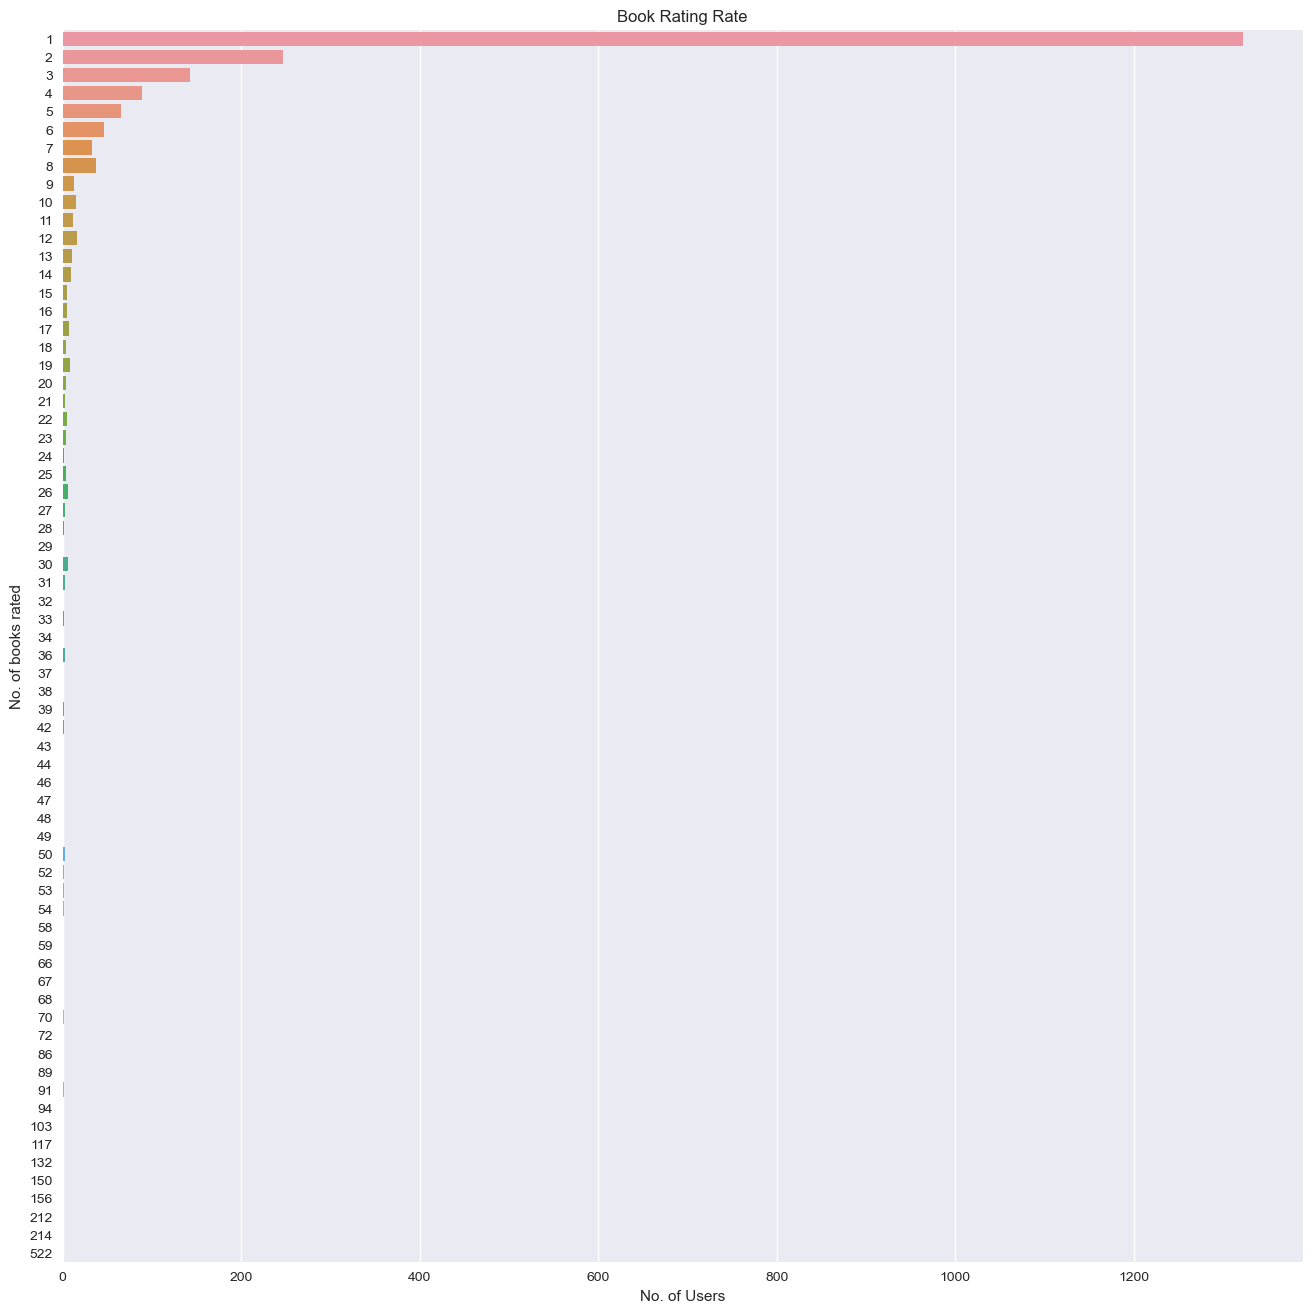

In [15]:
# Barplot of the number of users who have rated a specific number of books
plt.figure(figsize = (16,16))
sns.barplot(rating_rate, x = 'n_users', y = 'n_books_rated', orient = 'h', errorbar = None)
plt.xlabel("No. of Users")
plt.ylabel("No. of books rated")
plt.title("Book Rating Rate")

We can see that most users have rated a very few books. This presents a problem for us as it will be difficult to apply Collabarative Filtering as the history of user preference for most users is very small

Text(0.5, 1.0, 'Frequency of Each Rating')

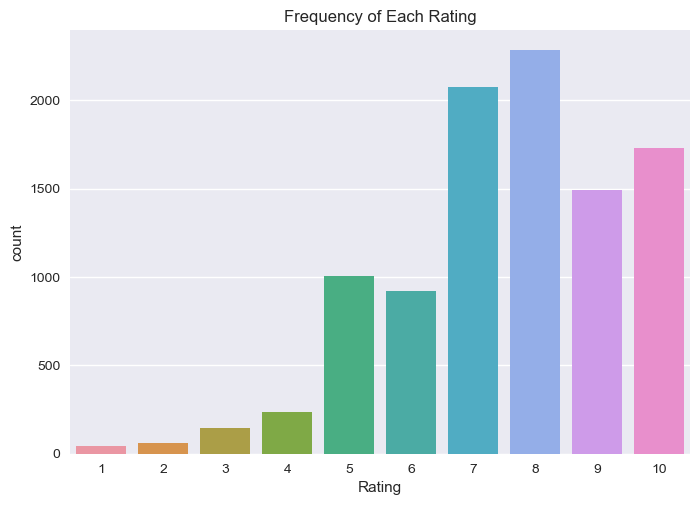

In [16]:
# Countplot for frequency of each rating
sns.countplot(books, x = 'book_rating')
plt.xlabel("Rating")
plt.title("Frequency of Each Rating")

The frequency for each rating seems to be rising exponentially, except for 5, 7, and 8 which seem to out do the pattern. This could be due to the user's tendency to give a rating of 5 of they don't feel strongly about the book, or 7 or 8 if they like the book but don't want to overstate its quality.

## Content Based Filtering

For content based filtering, ideally we should have different parameters for the items to b filtered. In this case, we would require book title, author, number of pages, series, etc parameters that factor into a reader's likeability of the book. However, here we only have the book_title. Hence, it will be difficult to provide good recommendations

In [17]:
# Making a copy of books dataframe
df = books.copy()

In [18]:
# Checking value count for a book
df.book_title.value_counts()

Fahrenheit 451                                              5
Stardust                                                    4
The Amber Spyglass (His Dark Materials, Book 3)             4
Ender's Game (Ender Wiggins Saga (Paperback))               4
The Subtle Knife (His Dark Materials, Book 2)               4
                                                           ..
Murder on St. Mark's Place (Gaslight Mysteries)             1
State of Grace                                              1
Valsalva's Maneuver: Mots Justes and Indispensable Terms    1
I love you, I hate you                                      1
Kids Say the Darndest Things                                1
Name: book_title, Length: 9659, dtype: int64

We can see that the title column contains the name of the series the book belongs too as well. But the data is not clean. We will have to clean it

Let's convert all characters to lowercase, so we don't have to worry about case-sensitivity : 

In [19]:
df['book_title'] = df.book_title.apply(lambda x : x.lower().strip())

In [20]:
# Creating an extra column with the length of the title
df['title_length'] = df.book_title.apply(lambda x: len(x))

In [21]:
# printing the top 50 longest title to check for patterns
for i in df.sort_values('title_length', ascending=False).book_title.head(50):
    print(i)

the american country inn and bed &amp; breakfast cookbook, volume i : more than 1,700 crowd-pleasing recipes from 500 american inns (american country inn &amp; bed &amp; breakfast cookbook (hardcover))
frankenstein: complete, authoritative text with biographical, historical, and cultural contexts, critical history, and essays from contemporary critic ... tive (case studies in contemporary criticism)
away for the weekend (r): southeast -- revised and updated edition : great getaways for every season in alabama, georgia, north carolina, south carolina and tennessee (away for the weekend series)
the world's shortest stories of love and death: passion, betrayal, suspicion, revenge, all this and more in a new collection of amazing short stories-each one just 55 words long
don't sweat the small stuff with your family : simple ways to keep daily responsibilities and household chaos from taking over your life (don't sweat the small stuff series)
don't sweat the small stuff at work : simple way

We can see that the title contain muliple special charaters. Not all titles contain text in parenthesis. Sometimes, text within parenthesis contain another set of text within parenthesis. The contents of parenthesis mostly contain the series name or publishing house name, or edition information. When series name is present, it is followed by the book number

In [22]:
# Finding encoding errors
for i in df[df.book_title.str.contains(r"&")].book_title:
    print(i)

mary-kate &amp; ashley switching goals (mary-kate and ashley starring in)
angels &amp; demons
the james dean affair: a neil gulliver &amp; stevie marriner novel
angels &amp; demons
angels &amp; insects : two novellas
the complete book of incense, oils &amp; brews (llewellyn's practical magick)
the western mysteries: an encyclopedic guide to the sacred languages &amp; magickal systems of the world : the key of it all, book ii (key of it all)
sheldon &amp; mrs. levine: an excruciating correspondence
skin: talking about sex, class &amp; literature
half moon street (charlotte &amp; thomas pitt novels (paperback))
wall street's picks for 2000: an insider's guide to the year's best stocks &amp; mutual funds (wall street's picks)
the amazing adventures of kavalier &amp; clay
notions and potions: a safe, practical guide to creating magic &amp; miracles
jack &amp; jill (alex cross novels)
so that others may live: caroline hebard &amp; her search-and-rescue dogs
in love &amp; trouble: stories of

In [23]:
# Removing encoding errors
df['book_title'] = df.book_title.str.replace("&amp;", 'and')
df['book_title'] = df.book_title.str.replace("&lt;i>", ': ')
df['book_title'] = df.book_title.str.replace("&lt;/i>", '')
df['book_title'] = df.book_title.str.replace(" &amp", '')

In [24]:
# Checking if each book_title has "(paper)"
for title in df[df.book_title.str.contains(r"\(paper\)")].book_title:
    print(title)

chicken soup for the woman's soul (chicken soup for the soul series (paper))
the pet shop mystery (boxcar children special (paper), no 7)
chicken soup for the mother's soul (chicken soup for the soul series (paper))
chicken soup for the parent's soul : 101 stories of loving, learning and parenting (chicken soup for the soul (paper))
captain underpants and the attack of the talking toilets: another epic novel (captain underpants (paper))
happy birthday, josefina!: a springtime story (american girls collection (paper))
josefina's surprise: a christmas story (american girls collection (paper))
meet addy: an american girl (american girls collection (paper))
meet josefina, an american girl (american girls collection (paper))
the case of the caretaker's cat (g k hall large print book series (paper))
samantha's surprise: a christmas story (american girls collection (paper))
changes for samantha: a winter story (american girls collection (paper))
meet samantha: an american girl (american girls

In [25]:
# Removing " (paper)" from the titles as it is irrelevant
df['book_title'] = df.book_title.apply(lambda x : x.replace(" (paper)", ""))

In [26]:
# Checking if each book_title has "(paperback)"
for title in df[df.book_title.str.contains(r" \(paperback\)")].book_title:
    print(title)

life's little instruction book (life's little instruction books (paperback))
el senor de los anillos: las dos torres (lord of the rings (paperback))
night mare (xanth novels (paperback))
body of evidence (kay scarpetta mysteries (paperback))
all that remains (kay scarpetta mysteries (paperback))
postmortem (kay scarpetta mysteries (paperback))
the silent cry (william monk novels (paperback))
moving pictures (discworld novels (paperback))
the picture of dorian gray (modern library (paperback))
emma (signet classics (paperback))
vinegar hill (oprah's book club (paperback))
liberty falling (anna pigeon mysteries (paperback))
killer market (deborah knott mysteries (paperback))
dragonflight (dragonriders of pern trilogy (paperback))
forever amber brown (amber brown (paperback))
the blue last: a richard jury mystery (richard jury mysteries (paperback))
shock wave (dirk pitt adventures (paperback))
hiding in the shadows (shadows trilogy (paperback))
my first book about space (golden look-look

In [27]:
# Removing " (paperback)" from the titles as it is irrelevant
df['book_title'] = df.book_title.apply(lambda x : x.replace(" (paperback)", ""))

In [28]:
# Checking if each book_title has "paperback"
for title in df[df.book_title.str.contains(r" \([^(]*paperback[^)]*\)")].book_title:
    print(title)

how not to say what you mean: a dictionary of euphemisms (oxford paperback reference s.)
calling on dragons (read with me paperbacks)
the capture (animorphs (paperback numbered))
the new oxford book of light verse (oxford paperbacks)
the stranger (animorphs (paperback numbered))
santas little helper sabrina the teenage witch 5 (sabrina, the teenage witch (numbered paperback))
war on the eastern front: the german soldier in russia, 1941-1945 (greenhill military paperbacks.)
pride and prejudice (everyman paperback classics)
it must have been an angel (redwood paperback; 119)
star wars: the truce at bakura (star wars (random house paperback))
dune (dune chronicles (berkley paperback))
the island of doctor moreau (everyman paperback classics)
the biggest house in the world (knopf children's paperbacks)
the canterbury tales (oxford paperbacks)
the wings of the dove (everyman paperback classics)
battlestations 31 (star trek (numbered paperback))
triangle (star trek (numbered paperback))
the 

In [29]:
# Removing every substring covered by parenthesis containing paperback
df['book_title'] = df.book_title.str.replace(r" \([^(]*paperback[^)]*\)", "")

C:\Users\harsh\AppData\Local\Temp\ipykernel_12340\80455357.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['book_title'] = df.book_title.str.replace(r" \([^(]*paperback[^)]*\)", "")


In [30]:
# Checking if each book_title has "paperback"
for title in df[df.book_title.str.contains(r" \([^(]*award[^)]*\)")].book_title:
    print(title)

true notebooks (alex awards (awards))
where no gods came (michigan literary fiction awards)
the eyre affair (alex awards (awards))
the dive from clausen's pier (alex awards)
the kite runner (alex awards (awards))
falling angel (rita award)
when the emperor was divine (alex awards (awards))


In [31]:
# Removing " (awards)"
df['book_title'] = df.book_title.str.replace(r" (awards)", "", regex=False)

In [32]:
# Removing any set of parenthesis containing awards
df['book_title'] = df.book_title.str.replace(r" \([^(]*award[^)]*\)", "", regex=True)

In [33]:
# Checking for titles containing 'award'
for title in df[df.book_title.str.contains("award")].book_title:
    print(title)

prize stories, 1987: the o'henry awards
rhoda : a life in stories tag: winner of the national book award for fiction
the darwin awards ii: unnatural selection
the essential 55: an award-winning educator's rules for discovering the successful student in every child


In [34]:
for title in df[df.book_title.str.contains("o'henry")].book_title:
    print(title)

prize stories, 1987: the o'henry awards


In [35]:
# Removing ": the o'henry awards"
df['book_title'] = df.book_title.str.replace(": the o'henry awards", "", regex=False)

In [36]:
# Removing ": the o'henry awards"
df['book_title'] = df.book_title.str.replace(": winner of the national book award for fiction", "", regex=False)

In [37]:
# Checking for titles containing 'winner'
for title in df[df.book_title.str.contains("winner")].book_title:
    print(title)

the new hugo winners, vol. 2
talking the winner's way: 92 little tricks for big success in business and personal relationships
a beautiful mind: a biography of john forbes nash, jr., winner of the nobel prize in economics, 1994
the lottery winner : alvirah and willy stories
winners and losers: the 1988 race for the presidency-one candidate's perspective


In [38]:
# Checking for titles containing 'hard'
for title in df[df.book_title.str.contains("hardcover")].book_title:
    print(title)

the cat who came to breakfast (cat who... (hardcover))
the last hero : a discworld fable (discworld novels (hardcover))
confessions of a sociopathic social climber : the katya livingston chronicles (katya livingston chronicles (hardcover))
vinegar hill (oprah's book club (hardcover))
the pilot's wife : a novel tag: author of the weight of water (oprah's book club (hardcover))
sudden mischief (spenser mysteries (hardcover))
daughter of fortune : a novel (oprah's book club (hardcover))
the clue of the velvet mask (nancy drew (hardcover))
sarah's child - hardcover
jupiter's bones: a novel (peter decker and rina lazarus novels (hardcover))
shadow of the hegemon (ender wiggins saga (hardcover))
the secret warriors (men at war (hardcover))
the body on the beach: a fethering mystery (fethering mysteries (hardcover))
the puzzled heart (kate fansler novels (hardcover))
orchid blues (holly barker novels (hardcover))
foundation's edge (foundation novels (hardcover))
the trouble with a hot summer:

In [39]:
# Removing " (hardcover)"
df['book_title'] = df.book_title.str.replace(" (hardcover)", "", regex=False)

In [40]:
# Removing " - hardcover"
df['book_title'] = df.book_title.str.replace(" - hardcover", "", regex=False)

We have eliminated obvious words that should not be used to identify a book. We could keep on trying to clean the text, however the benefit from these differences will be incrementally smaller. Instead we will use Term Frequency - Inverse Document Frequency Vectorizer to calculate similarity between book titles. TfIdf checks for the frequency of a word or a set of words in a title to match it with titles with similar frequencies. However, it becomes apparent that some common words like the ones we eliminated above (viz. hardcover, award, paperback) and others we have not eliminated like 'trilogy', 'series', etc will wrongly create similarity between many titles. Here, Inverse Document Frequency tracks the frequency of a word in all the titles, and if occurs in a large fraction of the titles, it's consideration into similarity is reduced.

In [41]:
# importing necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text

In [42]:
# Convert book_title column to TF-IDF vectors by trying to match a single word upto a set of 5 words
tfidf = TfidfVectorizer(ngram_range=(1,5), stop_words="english")
tfidf_matrix = tfidf.fit_transform(df["book_title"])

In [43]:
# Calculate cosine similarity between each entry
cos_sim = cosine_similarity(tfidf_matrix)

In [44]:
# Each entry will have maximum similarity score of 1 with itself. We will convert these to 0
np.fill_diagonal(cos_sim, 0)

In [45]:
# Function which returns indices for entries containing the passed string in it's book_title column
def get_index(title):
    # Getting a dataframe of entries containing the passed string as a substring in book_title column
    temp_df = df[df.book_title.str.contains(title, regex=False)]
    # If no entry contains the passed substring
    if temp_df.shape[0] == 0:
        return -1
    else:
        # Getting a list of entries containing the substring
        indexes = temp_df.index.tolist()
        # choosing a random entry among them
        rand_index = np.random.randint(len(indexes))
        # returning the random entry
        return indexes[rand_index]

In [46]:
# Getting a list of popular book incase no similarity found

# Grouping by book title and getting the count and sum of its ratings
ratings_df = df.groupby('book_title').agg(['count', 'sum']).book_rating
# Some books have been rated highly by only 1 user, some have been rated by multiple users and have a slightly lower rating. 
# Sorting by rating, will give us books highly rated by single users. We want to avoid this.
# So, we will consider each book has a new user rating it as 0 and then get the average rating
ratings_df['weighted_rating'] = ratings_df.apply(lambda x : x['sum']/(x['count'] + 1), axis = 1)
# Getting a list of top 10 books of the weighted average rating
pop_books = ratings_df.sort_values('weighted_rating', ascending=False).index[:10].tolist()

In [47]:
# Function to get recommendations based on cosine similarity between titles
def content_recommender(title):
    # Get one of the index of entry that contains the passed substring
    idx = get_index(title)
    # if no match is found
    if idx == -1:
        print("Book not found in library. Try again.")
        print("Meanwhile, you might want to consider these popular books : ")
        for book in pop_books:
            print("\t", book)
    else:  
        # Get cosine similarity for each entry with the obtained index; enumerate returns the index with the similarity value
        sim_scores = list(enumerate(cos_sim[idx])) 
        # Sorting in descending order based on similarity value
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Keeping only the 10 most similar titles
        sim_scores = sim_scores[:10]
        # Get indices of those top 10 books
        book_indices = [i[0] for i in sim_scores]
        # Return titles for these indices
        return df["book_title"].iloc[book_indices]

In [48]:
# Getting Content Based Recommendations
content_recommender("star wars")

8463    edge of victory ii: rebirth (star wars: the ne...
1302                       return of the jedi (star wars)
3881           star wars: the truce at bakura (star wars)
2090                                           after dark
5781                                           until dark
6888                             the dark side of nowhere
3882    jedi search (star wars: the jedi academy trilo...
2057                    a guide to the star wars universe
5280                                            high tide
3646    the way of the apprentice (star wars: jedi que...
Name: book_title, dtype: object

## Item Based Collaborative Filtering

With Item-based Collaborative Filtering, we will find similarity in patterns for ratings given to a particular book title. Then, for a given user, we will recommend titles similar to the ones highly rated by the user

In [49]:
# Removing the title_length column as it is not relevent now
df.drop(columns = ['title_length'], inplace = True)

In [50]:
# Pivoting the datframe so that book_title are the indices, user_id are the columns, and book_ratings are the values
book_user_df = df.pivot_table(index = 'book_title', columns='user_id', values='book_rating')

In [51]:
# Replacing the na values with 0
book_user_df.fillna(0, inplace=True)

In [52]:
# Calculating cosine similarity for each book_title
cos_sim = cosine_similarity(book_user_df)

In [53]:
# Replacing similarity of each book_title with itself with 0
np.fill_diagonal(cos_sim, 0)

In [54]:
# Creating a dataframe of the similarity values
book_sim_df = pd.DataFrame(cos_sim, index = book_user_df.index, columns=book_user_df.index)

In [55]:
# Function to return a list of titles with any similarity with the passed title
def give_sim_books(book):
    sim_books = pd.DataFrame(book_sim_df[book].sort_values(ascending = False))
    return sim_books[sim_books[book] > 0].index.tolist()

In [56]:
# Function to get titles with ratings higher than 5 for the passed user id
def get_top_books(user_id):
    return df[(df.user_id == user_id) & (df.book_rating > 5)].sort_values('book_rating', ascending=False).book_title.tolist()

In [57]:
# Function to show recommendations using Item-based Collaborative Filtering
def item_colab_recommender(user_id):
    # Creating empty list of recommendations
    recs = []
    # Getting titles with ratings higher than 5 for this user
    best_books = get_top_books(user_id)
    for book in best_books:
        # Getting similar books
        temp_recs = give_sim_books(book)
        # If similar titles exist
        if temp_recs:
            for t in temp_recs:
                # Add to recommendations
                recs.append(t)
    # If no recommendations generated, suggest popular titles
    if not recs:
        print("There don't seem to be any recommendations for your books.\nHowever, you might enjoy these popular books : ")
        for book in pop_books:
            print("\t", book)
    else:
        # Creating a list of titles already rated by user
        read_list = df[df.user_id == user_id].book_title.tolist()
        # Creating list of titles in recommendations not rated by user
        recs = [i for i in recs if i not in read_list]
        # Limiting recommendations to 10 titles
        if len(recs) > 10:
            recs = recs[:10]
        print("You might like the following books : ")
        for r in recs:
            print("\t", r)

In [58]:
# Getting user ids for highest and lowest numbers of books rated
df.user_id.value_counts()

3757      522
162052    214
2276      212
4017      156
277427    150
         ... 
969         1
967         1
965         1
951         1
162129      1
Name: user_id, Length: 2182, dtype: int64

In [59]:
# Getting recommendations for passed user id using Item-based Collaborative Filtering
item_colab_recommender(4017)

You might like the following books : 
	 the silent service: los angeles class
	 done driftin' (the dunleavy legacy) (harlequin superromance, no 654)
	 supercarrier: an inside account of life aboard the world's most powerful ship, the uss john f. kennedy
	 just over the mountain
	 american pastoral
	 kaleidoscope
	 cw2    (co)
	 treasure-cussler
	 the guns of avalon (chronicles of amber)
	 beneath the silent sea


In [60]:
# Getting recommendations for passed user id using Item-based Collaborative Filtering
item_colab_recommender(162129)

There don't seem to be any recommendations for your books.
However, you might enjoy these popular books : 
	 flesh and blood
	 the subtle knife (his dark materials, book 2)
	 the face
	 housekeeping
	 the gift
	 2nd chance
	 still life with woodpecker
	 tiger prince
	 breathing lessons
	 the amber spyglass (his dark materials, book 3)


## User Based Collaborative Filtering

In User-based Collaborative Filtering, we find similarities in patterns of ratings given to different books by a user. Then, we will recommend highly-rated titles of other similar users

In [61]:
# Pivoting the datframe so that user_id are the indices, book_title are the columns, and book_ratings are the values
user_book_df = df.pivot_table(index='user_id', columns='book_title', values='book_rating')

In [62]:
# Replacing the na values with 0
user_book_df.fillna(0, inplace = True)

In [63]:
# Calculating cosine similarity for each user_id
cos_sim = cosine_similarity(user_book_df)

In [64]:
# Replacing similarity of each user_id with itself with 0
np.fill_diagonal(cos_sim, 0)

In [65]:
# Creating a dataframe of the similarity values
user_sim_df = pd.DataFrame(cos_sim, index = user_book_df.index, columns=user_book_df.index)

In [66]:
# Function to return a list of user ids with any similarity with the passed user id
def give_sim_users(user_id):
    sim_users = pd.DataFrame(user_sim_df[user_id].sort_values(ascending = False))
    return sim_users[sim_users[user_id] > 0].index.tolist()

In [67]:
# Getting similar users to the passed user id
give_sim_users(162129)

[]

In [68]:
# Getting similar users to the passed user id
give_sim_users(4017)

[161542, 161730, 277188, 277378, 2439, 276939, 277965, 278582, 161974]

In [69]:
# Function to show recommendations using User-based Collaborative Filtering
def user_colab_recommender(user_id):
    # Creating empty list of recommendations
    recs = []
    # State of whether popular recommendations are given set to False
    pop_given = 0
    # Getting list of similar user ids
    sim_users = give_sim_users(user_id)
    # If no similar users found
    if not sim_users:
        print("There don't seem to be any recommendations for your books.\nHowever, you might enjoy these popular books : ")
        for book in pop_books:
            print("\t", book)
        # Popular recommendations given and its state set to True
        pop_given = 1
    else:
        for user in sim_users:
            ratings = pd.DataFrame(user_book_df.loc[user].sort_values(ascending = False))
            ratings.columns = ['rating']
            # Getting titles with rating higher than 5 for each similar user
            recs += ratings[ratings.rating > 5].index.tolist()
        # If no recommendations generated
        if not recs:
            # Give popular recommendations if previously not given
            if not pop_given:
                print("There don't seem to be any recommendations for your books.\nHowever, you might enjoy these popular books : ")
                for book in pop_books:
                    print("\t", book)
        else:
            
            # Creating a list of titles already rated by user
            read_list = df[df.user_id == user_id].book_title.tolist()
            # Creating list of titles in recommendations not rated by user
            recs = [i for i in recs if i not in read_list]
            # Limiting recommendations to 10 titles         
            if len(recs) > 10:
                recs = recs[:10]
            print("You might like the following books : ")
            for r in recs:
                print("\t", r)  

In [70]:
# Getting recommendations for passed user id using User-based Collaborative Filtering
user_colab_recommender(4017)

You might like the following books : 
	 karl marx: a life
	 the pet shop mystery (boxcar children special, no 7)
	 in the bleak midwinter (a rev. clare ferguson mystery)
	 the golden compass (his dark materials, book 1)
	 socks (cleary reissue)
	 johnny under ground (inspector henry tibbett mystery)
	 playboy sheikh (man of the month/sons of the desert) (silhouette desire, no. 1417)
	 lady of avalon
	 daughters of the moon: night shade - book #3 (daughters of the moon, 3)
	 quoth the raven


In [71]:
# Getting recommendations for passed user id using User-based Collaborative Filtering
user_colab_recommender(162129)

There don't seem to be any recommendations for your books.
However, you might enjoy these popular books : 
	 flesh and blood
	 the subtle knife (his dark materials, book 2)
	 the face
	 housekeeping
	 the gift
	 2nd chance
	 still life with woodpecker
	 tiger prince
	 breathing lessons
	 the amber spyglass (his dark materials, book 3)


## Conclusion

With sufficient metadata, we can include content based filtering when we don't have a history of user's preferences. Once a preference history is generated, we can use item-based collaborative filtering if the numbers of items are higher than users, and User-based collaborative filtering if we have a large userbase. We can also create a hybrid filteration system based on the aspects of these different systems that apply to our data.